### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision 
import torch.nn.functional as F  
import torchvision.datasets as datasets  
import torchvision.transforms as transforms 
from torch import optim  
from torch import nn  
from torch.utils.data import DataLoader 
from tqdm import tqdm  
from torchmetrics import F1Score, ConfusionMatrix

### Hyperparameters

In [2]:
input_size = 784
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 35

### Training and Testing Dataset

In [3]:
torch.manual_seed(0)
train_dataset = datasets.MNIST(root='dataset/',train = True, transform=transforms.ToTensor(),download=True)
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_dataset = datasets.MNIST(root='dataset/',train = False, transform=transforms.ToTensor(),download=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

In [4]:
images, labels = next(iter(train_loader))

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


tensor(6)

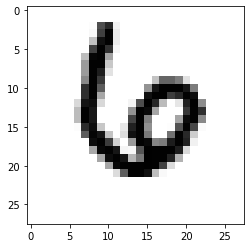

In [5]:
#plotting a single image
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');
labels[0]

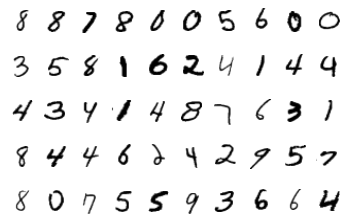

In [6]:
#plotting multiple input images
figure = plt.figure()
num_of_images = 50
for index in range(1, num_of_images + 1):
    plt.subplot(5, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### Network Architecture

In [7]:
#Build a fully connected neural network
class NN(nn.Module):
    def __init__(self, input_size, num_classes,dropout):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64,num_classes)
        self.dropout = nn.Dropout(p = dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Initialize Network

In [9]:
torch.manual_seed(0)
model = NN(input_size=input_size, num_classes=num_classes,dropout = 0.1).to(device)

#cost function
criterion = nn.CrossEntropyLoss()

#Optimization algorithm
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

### Train Network

In [10]:
torch.manual_seed(0)
loss_after_epoch = []
for epoch in range(num_epochs):
    running_loss = 0
    for batch_idx,(data,targets) in enumerate(tqdm(train_loader)):
        data = data.to(device=device)
        targets = targets.to(device = device)
        
        #make data into 64,784 i.e. get the correct shape
        data = data.reshape(data.shape[0], -1)
        
        #forward 
        scores = model(data)
        loss = criterion(scores,targets)
        
        #backward 
        optimizer.zero_grad()  
        loss.backward()
        
        #gradient descent
        optimizer.step() 
        
        running_loss += loss.item() 
    loss_after_epoch.append(running_loss/len(train_loader))


100%|███████████████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 129.82it/s]


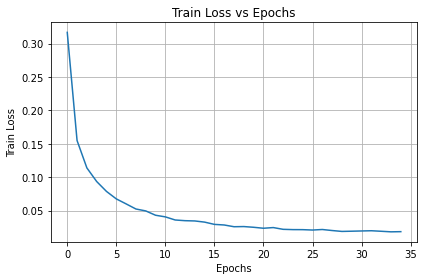

In [11]:
#Plot training loss against epochs
x = np.arange(0,num_epochs)
plt.plot(x,loss_after_epoch)
plt.grid(True)
plt.title("Train Loss vs Epochs")
plt.xlabel('Epochs')
plt.ylabel('Train Loss') 
plt.tight_layout()
plt.show()

### Evaluation

In [12]:
def evaluation(loader, model):
    model.eval()
    
    num_correct = 0
    num_samples = 0
    predicted = torch.Tensor()
    actual = torch.Tensor()
    
    with torch.no_grad():
        for x, y in loader:
            
            x = x.to(device=device)
            y = y.to(device=device)
            actual = torch.cat((actual,y.reshape(-1)))

            # Get to correct shape
            x = x.reshape(x.shape[0], -1)

            # Forward pass
            scores = model(x)
            _, predictions = scores.max(1)
            predicted = torch.cat((predicted,predictions.reshape(-1)))
            #keep track of number of correctly classified samples
            num_correct += (predictions == y).sum()

            # Keep track of number of samples
            num_samples += predictions.size(0)
            
    # Check how many we got correct
    accuracy = num_correct/num_samples 
    
    predicted = predicted.type(torch.int64)
    actual = actual.type(torch.int64)
    
    cm = ConfusionMatrix(10)
    df = pd.DataFrame((cm(predicted,actual)).cpu().numpy())
    print("Confusion matrix: ")
    print(df)
    
    #summation of the prediction of all the single classes
    pre = df.sum(axis = 0)
    #summation of ground truths of every individual digit in the dataset 
    act = df.sum(axis = 1)
    
    f1 = F1Score(10)
    
    #calculate percentage of class accuracy 
    class_accuracy = []
    for i in range(num_classes):
        class_accuracy.append((df.loc[i,i]/act[i])*100)
    
    return (class_accuracy,accuracy,f1(predicted,actual))
    
train_class_per, train_class_acc, train_f1 = evaluation(train_loader,model)
test_class_per, test_class_acc, test_f1 = evaluation(test_loader,model)

Confusion matrix: 
      0     1     2     3     4     5     6     7     8     9
0  5916     0     3     1     0     0     2     0     0     1
1     0  6741     0     1     0     0     0     0     0     0
2     0     1  5956     0     0     0     1     0     0     0
3     0     0     4  6127     0     0     0     0     0     0
4     1     2     0     0  5826     0     0     1     0    12
5     0     0     0     5     0  5416     0     0     0     0
6     0     0     0     0     0     2  5915     0     1     0
7     0     2     2     2     0     1     0  6258     0     0
8     0     3     5     2     0     1     0     0  5838     2
9     0     0     0     2     0     0     0     0     0  5947
Confusion matrix: 
     0     1     2    3    4    5    6     7    8    9
0  969     0     3    1    1    1    3     1    1    0
1    0  1127     2    1    0    1    2     1    1    0
2    1     0  1023    4    0    0    1     2    1    0
3    0     0     4  995    0    3    0     1    5    2
4    

In [13]:
# accuracy and F1 score 
print(f"Accuracy on training set: {train_class_acc*100:.2f}")
print(f"f1 score is: {train_f1.cpu().numpy()*100:.2f}")
print(f"Accuracy on test set: {test_class_acc*100:.2f}")
print(f"f1 score is: {test_f1.cpu().numpy()*100:.2f}")

Accuracy on training set: 99.90
f1 score is: 99.90
Accuracy on test set: 98.15
f1 score is: 98.15


In [14]:
#Test and train accuracy of every class in the dataset
df_train = pd.DataFrame(np.array(train_class_per).reshape(10,1))
df_test = pd.DataFrame(np.array(test_class_per).reshape(10,1))
df = pd.concat([df_train,df_test],axis = 1)
df.columns = ['train_acc_per_digit','test_acc_per_digit']
df

,train_acc_per_digit,test_acc_per_digit
0,99.881817,98.877551
1,99.985168,99.295154
2,99.966432,99.127907
3,99.934758,98.514851
4,99.726121,96.741344
5,99.907766,97.421525
6,99.949307,98.434238
7,99.888268,97.276265
8,99.777816,97.433265
9,99.966381,98.116947


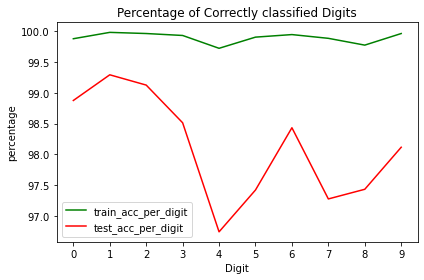

In [15]:
#plot class percentage of every digit class
x = np.arange(0,10)
plt.plot(x,np.array(train_class_per),'g',label = 'train_acc_per_digit')
plt.plot(x,np.array(test_class_per),'r',label = 'test_acc_per_digit')
plt.title('Percentage of Correctly classified Digits')
plt.xlabel('Digit')
plt.ylabel('percentage') 
#plt.grid(True)  
plt.xticks(ticks=x) 
plt.tight_layout()
plt.legend()

plt.savefig("fcn_class_accuracy.png")

plt.show()